# Consolidação do Conteúdo - Aprendizado de Máquina



***

# Dataset

O tema do dataset escolhido é Pokémon. Os Pokémons são mundialmente conhecidos e são destacados por cada criatura ter suas características únicas que as definem. O dataset escolhido para esse trabalho conta com uma lista de 13 características e 1072 Pokémons.

As características são:
- __Number__ (_Número_): É o ID de cada Pokémon.
- __Name__ (_Nome_): É o nome de cada Pokémon.
- __Type 1__ (_Tipo 1_): É o primeiro tipo do Pokémon. Todo Pokémon têm o primeiro tipo.
- __Type 2__ (_Tipo 2_): É o segundo tipo do Pokémon. Alguns Pokémon não têm segundo tipo.
- __Total__ (_Total_): Soma de todas as estatísticas (Ataque, Defesa, Sp. Ataque, Sp. Defesa e Speed). Este valor é muito importante para determinar se o Pokémon é forte ou não.
- __Attack__ (_Ataque_): Valor da força física do Pokémon.
- __Defense__ (_Defesa_): Valor da resistência física do Pokémon.
- __SP Attack__ (_Ataque Especial_): Valor da força mágica do Pokémon.
- __SP Defense__ (_Defesa Especial_): Valor da resistência mágica do Pokémon.
- __Speed__ (_Velocidade_): Valor da velocidade do Pokémon, esse valor determina qual Pokémon ataca primeiro.
- __Generation__ (_Geração_): A geração de jogos em que o Pokémon teve sua primeira introdução.
- __Legendary__ (_Lendário_): Alguns Pokémons são mais raros que outros, e eles são chamadas de "lendários".
- __Stage__ (_Estágio de Evolução_): Muitos Pokémon tem a capacidade de evoluir para formas mais poderosas. Pokémon que nunca evoluem são considerados básicos (Basic), os que evoluiram 1 vez são Estágio 1 (Stage 1) e os que evoluiram 2 vezes são chamados de Estágio 2 (Stage 2). Existem mecânicas de jogos que dão aos Pokémons novas formas, como as Mega evoluções (Mega) e as formas Gigantamax (Gigantamax).

<br>
<br>

Como pode ser observado pelos dados fornecidos pelo dataset, e pela experiência própria com a franquia do autor deste arquivo de código  com a franquia Pokémon, não é possível afirmar com 100% de acertividade que um Pokémon é do tipo Água, Fogo ou qualquer outro tipo pelas suas estatísticas, sua geração ou se é lendário ou não. Na página do dataset, o próprio autor comenta:


>O tipo de um Pokémon não pode ser inferido apenas pelo seu Ataque e Defesa. Valeria a pena descobrir quais duas variáveis ​​podem definir o tipo de um pokémon, se houver. Duas variáveis ​​podem ser plotadas em um espaço 2D e usadas como exemplo para aprendizado de máquina. Isso pode significar a criação de um exemplo visual que qualquer turma geek de aprendizado de máquina adoraria.

<br>

Entretanto, os Pokémons que pertencem a um certo tipo seguem uma tendência. Segundo o Bulbapedia, um site expecializado em informações da franquia Pokémon, o tipo eletric (elétrico) tem em média 85,94 de velocidade entre todos os Pokémon desse tipo, em contra-partida os do tipo ground (terra) tem somente 61,13 de velocidade. Com essa informações, é possível prever que a probabilidade de um Pokémon que tem 90 de velocidade é maior de ser do tipo elétrico do que terra. Pontanto essa database pode ser uma ótima escolha para testar os algoritmos de aprendizado de máquina.

In [155]:
# Todos os imports global necessários para este arquivo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
import random

In [156]:
data = pd.read_csv('Pokemon.csv')

In [157]:
# Remover todos os Pokémon na forma Mega ou Gigantamax por ter valores indenticos a sua forma original ou que tenham estatísticas muito distoantes dos outros Pokémon.

data_len_b = len(data)

data = data[~data['stage'].str.contains('Mega')]
data = data[~data['stage'].str.contains('Gigantamax')]


# O Pokémon do indice 1057 possui valores muito distoantes de todos os outros elementos. Então será desconsiderado.

data = data[~data['name'].str.contains('Eternamax ')]

data_len_a = len(data)

print(f"Foram removidos {data_len_b - data_len_a} registros de Pokémons.")

Foram removidos 84 registros de Pokémons.


In [158]:
for column in data.columns:
  print(f'{column:>12}: {len(set(data[column])):4} {data[column].dtype}')

      number:  898 int64
        name:  988 object
       type1:   19 object
       type2:   19 object
       total:  203 int64
          hp:  103 int64
      attack:  118 int64
     defense:  109 int64
   sp_attack:  112 int64
  sp_defense:  105 int64
       speed:  127 int64
  generation:    9 int64
   legendary:    2 bool
       stage:    4 object


***

# Regressão

Com o método da regressão, queremos prever um valor contínuo de variáveis independentes em relação a uma variável dependente. O valor total (total) das estatísticas do Pokémon está relacionado com os valores de todas as estatísticas, então podemos observar que, se um Pokémon tem um valor de ataque (attack) muito alto, é provavel que o seu total (total) também sejá alto.

Para observar essa relação, utilizaremos a regressão linear para prever o valor total (total) de um Pokémon fornecendo somente seu valor de ataque (attack).

### Tratamento dos Dados

Separar os dados da variável independente (X) e os dados da variável dependente (y).

In [159]:
X = data['attack'].values.reshape(-1,1)
y = data['total'].values

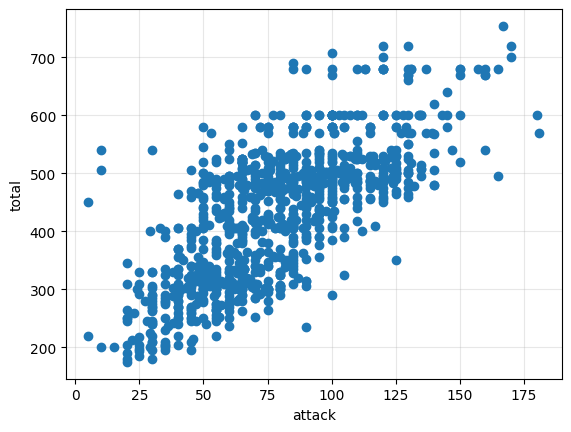

In [160]:
plt.xlabel(f"{data['attack'].name}")
plt.ylabel(f"{data['total'].name}")
plt.scatter(data['attack'], data['total'], zorder=2)
plt.grid(alpha=0.3)
plt.show()

Como os valores dos dados de __X__ e razão de __y__ é alta, será necessário realizar a padronização dos dados de __X__. Será utilizado o StandardScaler() para padronização dos valores.

In [161]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

### Algoritmos

A Raiz do Erro Quadrático Médio (RMSE) é simplesmente a raiz quadrada do MSE. Isso é feito para retornar à métrica à mesma escala que os valores reais, o que facilita a interpretação. 

In [162]:
# Raiz do Erro Quadrático Médio (RMSE)

from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y, ypred):
  mse = mean_squared_error(y, ypred)
  return sqrt(mse)

Abaixo está o algoritmo de Regressão Linear "manualmente" implementado. O algoritmo contém o método fit() para treinar os pesos (w) e utilizá-los posteriormente no método predict(). O algoritmo também contém um método de adição de bias para não ficar preso na origem.

Raiz do Erro Quadrático Médio (RMSE): 79.51881458945789


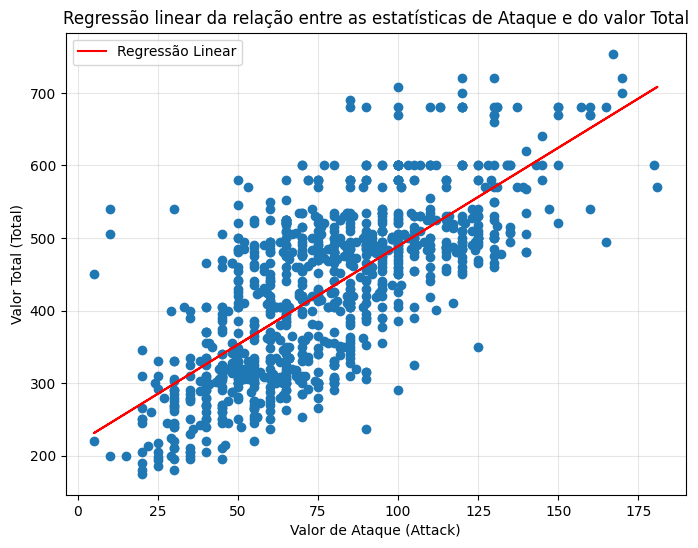

In [163]:
# Regressão Linear

class LinearRegression_M(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self, learning_rate=0.1, n_iter=500):
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.w = np.zeros((2,1))
  
  @staticmethod
  def addBias(X):
    bias = np.ones((X.shape[0],1))
    X_b = np.concatenate((bias,X),axis=1)
    return X_b
  
  def fit(self, X, y):
    X_b = self.addBias(X)
    for _ in range(self.n_iter):
      ypred = self.predict(X)
      erro = ypred - y.reshape(-1,1)
      ajuste = X_b.T.dot(erro)/X_b.shape[0]
      self.w = self.w - self.learning_rate * ajuste

  def predict(self, X):
    X_b = self.addBias(X)
    y = X_b.dot(self.w)
    return y



linearRegression_m = LinearRegression_M()
linearRegression_m.fit(X_new, y)
ypred = linearRegression_m.predict(X_new)

print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse(y,ypred)}")
plt.figure(figsize=(8,6))
plt.scatter(X, y, zorder=2)
plt.title("Regressão linear da relação entre as estatísticas de Ataque e do valor Total")
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.plot(X, ypred, 'r', label="Regressão Linear")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Para fins de comparação, abaixo é importado o modelo LinearRegression() da biblioteca Scikit-learn. Em tese, tanto a implementação manual quanto o modelo importado devem apresentar os mesmos resultados.

A única diferença encontrada pelo autor deste documento foi a capacidade do modelo de Regressão Linear da biblioteca Scikit-learn de utilizar os dados de entrada (X) sem a necessidade de estarem padronizados. O modelo manual apresenta problemas de overflow devido à diferença entre a escala dos valores de __X__ e __y__.

Raiz do Erro Quadrático Médio (RMSE): 79.51881458945789


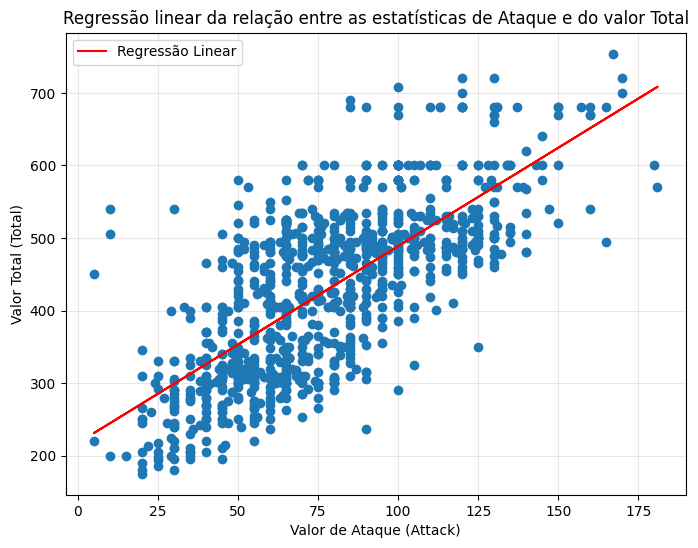

In [164]:
# Regressão Linear do modelo presente em sklearn

from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()
linearRegression.fit(X, y)
ypred = linearRegression.predict(X)



print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse(y,ypred)}")
plt.figure(figsize=(8,6))
plt.scatter(X, y, zorder=2)
plt.title("Regressão linear da relação entre as estatísticas de Ataque e do valor Total")
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.plot(X, ypred, 'r', label="Regressão Linear")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo de Regressão Linear "manual" possui dois parâmetros principais: o n_iter, que determina quantas iterações o método fit() realizará durante o treinamento dos pesos (w), e o learning_rate, que define a taxa de aprendizado aplicada em cada iteração.

Por outro lado, o algoritmo da biblioteca do Scikit-learn utiliza estratégias internas otimizadas para obter resultados eficientes. Portanto, não é necessário submetê-lo ao GridSearchCV() para busca de melhores parâmetros, pois essas otimizações já são implementadas internamente.

In [165]:
from sklearn.model_selection import GridSearchCV, cross_validate

parameters = {
  'n_iter':[20, 100, 500, 1000],
  'learning_rate': [0.001, 0.01, 0.1]
  }

gs_lrm_model = GridSearchCV(LinearRegression_M(), parameters, scoring="neg_root_mean_squared_error")
linearReg_M_scores = cross_validate(gs_lrm_model, X_new, y, scoring="neg_root_mean_squared_error")

linearReg_scores = cross_validate(LinearRegression(), X_new, y, scoring="neg_root_mean_squared_error")

In [166]:
lr_M_mean = linearReg_M_scores['test_score'].mean()
lr_mean = linearReg_scores['test_score'].mean()

print(f'Desempenho médio de RMSE da Regressão Linear (manual):       {(1 - lr_M_mean):.3f}')
print(f'Desempenho médio de RMSE da Regressão Linear (Scikit-learn): {(1 - lr_mean):.3f}')

Desempenho médio de RMSE da Regressão Linear (manual):       80.805
Desempenho médio de RMSE da Regressão Linear (Scikit-learn): 80.806


### Captura e Interpretação dos resultados

Nos testes de hiperparâmetros e validação cruzada, observou-se que tanto a implementação manual quanto a implementada com o Scikit-learn apresentam desempenhos semelhantes. Portanto, optou-se por utilizar a classe LinearRegression() importada do sklearn.

<br>

Para obter resultados mais confiáveis, os dados serão separados em conjuntos de treinamento e teste.

In [167]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [168]:
# Treinamento do modelo com os dados de treinamento.

model = LinearRegression()
model.fit(X_train, y_train)
ypred = model.predict(X_test)

O modelo treinado com LinearRegression() apresentou um coeficiente de 2,729 e um intercepto de 217,601. Isso indica que, para cada aumento de 1 ponto no atributo de Ataque de um Pokémon, espera-se um acréscimo de aproximadamente 2,729 pontos nas estatísticas Totais, além de uma constante de 217,601 pontos.

In [169]:
print(f'Coeficiente: {model.coef_[0]:.3f}')
print(f'Constante: {model.intercept_:.3f}')

Coeficiente: 2.729
Constante: 217.601


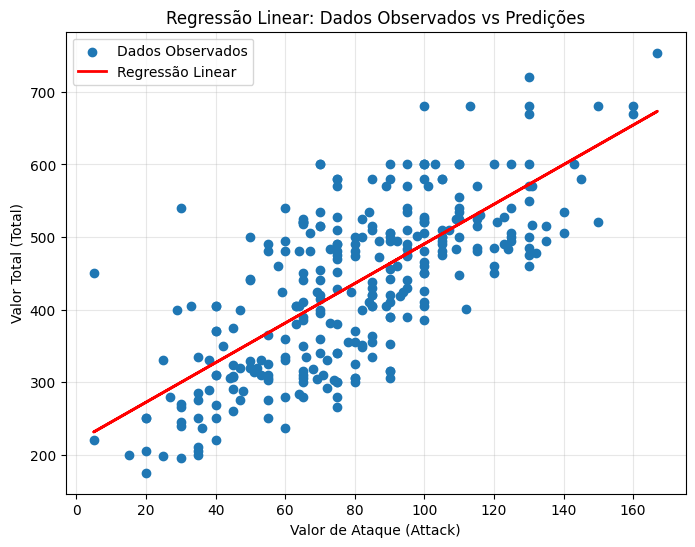

In [170]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, label='Dados Observados', zorder=2)
plt.plot(X_test, ypred, color='red', linewidth=2, label='Regressão Linear')
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.title('Regressão Linear: Dados Observados vs Predições')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Dado o coeficiente significativo para o Ataque, é possível concluir que esse atributo tem uma influência substancial no Total das estatísticas dos Pokémon no conjunto de dados. Isso sugere que o Ataque (attack) é um preditor crucial para determinar as estatísticas gerais de um Pokémon.

<br>
<br>
<br>
<br>
<br>

***

# Classificação

A classificação é uma forma de aprendizado supervisionado cujo objetivo é prever a categoria de uma nova observação com base em um conjunto de treinamento de observações cujas categorias são conhecidas. Pokémons considerados lendários são geralmente muito poderosos, refletindo em altos valores de estatísticas totais.

Será empregado um algoritmo de classificação para determinar se os Pokémons são ou não lendários com base nas estatísticas totais.

### Classificação Linear

O algoritmo de classificação linear separa as amostras em dois grupos distintos. Por serem distintos, haverá somente dois grupos. Então o processo da classificação desses dois grupos consiste em primeiro construir uma regressão linear e depois é definido um ponto de corte em relação a essa regressão linear, que geralmente é 0,5. Os elementos que estiverem acimaa do corte irão pertencer a classe, enquando os abaixo não.

##### Tratamento dos Dados

Para realizara classificação dos dados, primeiro vamos separar os dados da variável independente (X) e os dados da variável dependente (y).

In [171]:
X = data['total'].values.reshape(-1,1)
y = data['legendary'].values

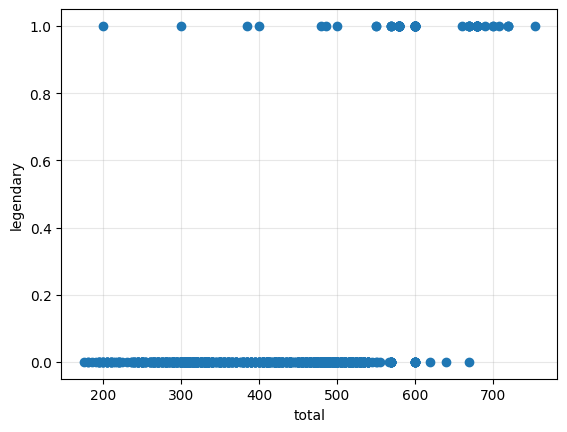

In [172]:
### Tratamento dos Dados
X = data['total'].values.reshape(-1,1)
y = data['legendary'].values
plt.xlabel(f"{data['total'].name}")
plt.ylabel(f"{data['legendary'].name}")
plt.scatter(data['total'], data['legendary'], zorder=2)
plt.grid(alpha=0.3)
plt.show()

##### Algoritmo

Abaixo está o algoritmo de Classificação Linear Binário implementado manualmente. O algoritmo realizar a Regressão Linear e, com as previsões, categoriza cada indivíduo como uma das características pela lógica __previsão > 0__.

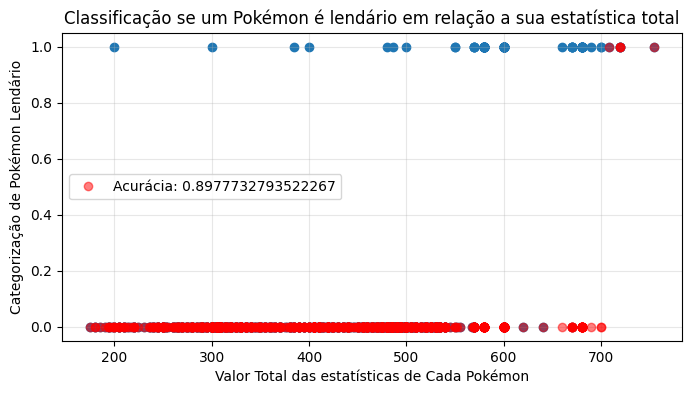

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

# Classificador Linear Binário implementado Manualmente


class LogisticRegressionB_M(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self):
    self.lrmodel = LinearRegression()
  def fit(self,X,y):
    self.lrmodel.fit(X,y)
  def predict(self, X):
    ypred = self.lrmodel.predict(X)
    ypred = (ypred>0.5).astype(int)
    return ypred



modelo = LogisticRegressionB_M()
modelo.fit(X,y)
ypred = modelo.predict(X)

acuracia = accuracy_score(y, ypred)

plt.figure(figsize=(8,4))
plt.scatter(X, y)
plt.xlabel("Valor Total das estatísticas de Cada Pokémon")
plt.ylabel("Categorização de Pokémon Lendário")
plt.plot(X, ypred,'ro', label=f"Acurácia: {acuracia}", alpha=0.5, zorder=2)
plt.title("Classificação se um Pokémon é lendário em relação a sua estatística total")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Abaixo é implementado o classificador linear da biblioteca do Scikit-learn.

Diferente do modelo de Regressão Linear implementado pelo autor desse documento em comparação ao do Scikit-learn, o algoritmo importado LogisticRegression() é mais preciso (maior acurácia) que o implementado.

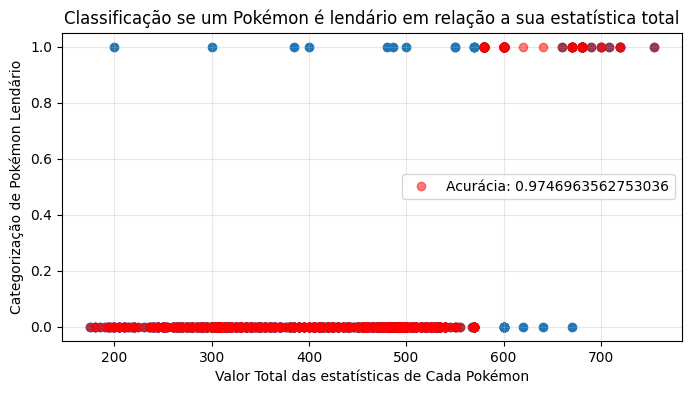

In [174]:
from sklearn.linear_model import LogisticRegression

# Classificador Linear do Scikit-learn


modelo = LogisticRegression()
modelo.fit(X,y)
ypred = modelo.predict(X)

acuracia = accuracy_score(y, ypred)

plt.figure(figsize=(8,4))
plt.scatter(X, y)
plt.xlabel("Valor Total das estatísticas de Cada Pokémon")
plt.ylabel("Categorização de Pokémon Lendário")
plt.plot(X, ypred,'ro', label=f"Acurácia: {acuracia}", alpha=0.5, zorder=2)
plt.title("Classificação se um Pokémon é lendário em relação a sua estatística total")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

##### Ajuste dos Hiperparâmetros e Validação Cruzada

Neste trabalho não será realizado busca por hiperparâmetros para o algoritmo de Classificação Linear.

Entretanto, para avaliar a capacidade do algoritmo de prever valores que não foram submetidos a testes, é necessário realizar a validação cruzada.

In [175]:
linearClass_M_scores = cross_validate(LogisticRegressionB_M(), X, y, scoring='accuracy')

linearClass_scores = cross_validate(LogisticRegression(), X, y, scoring='accuracy')


In [176]:
lr_M_mean = linearClass_M_scores['test_score'].mean()
lr_mean = linearClass_scores['test_score'].mean()

print(f'Desempenho médio de Acurácia da Classificação Linear (manual):       {lr_M_mean:.3f}')
print(f'Desempenho médio de Acurácia da Classificação Linear (Scikit-learn): {lr_mean:.3f}')

Desempenho médio de Acurácia da Classificação Linear (manual):       0.899
Desempenho médio de Acurácia da Classificação Linear (Scikit-learn): 0.950


### Captura e Interpretação dos resultados

Nos testes de validação cruzada, o algoritmo importado da biblioteca do Scikit-learn teve melhor desempenho em comparação ao algoritmo implementado, portando para a captura e interpretação dos resultados, será usado o algoritmo do sklearn LogisticRegression().

<br>

Para obter resultados mais confiáveis, os dados serão separados em conjuntos de treinamento e teste.

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [178]:
# Treinamento do modelo com os dados de treinamento.

model = LogisticRegression()
model.fit(X_train, y_train)
ypred = model.predict(X_test)

Após treinar o modelo LogisticRegression() do Scikit-learn com dados de treino (X_train e y_train), foi obtido uma acurácia de aproximadamente 94% utilizando os dados de testes (X_test e y_test). Os valores do coeficiente e do interceptador encontrados para formar a fronteira de decisão foi respectivamente de 0,04 e -23,203. 

In [179]:
print(f'Coeficiente: {model.coef_[0][0]:.3f}')
print(f'Constante:  {model.intercept_[0]:.3f}')
print(f'Acurácia:    {accuracy_score(y_test, ypred):.3f}')

Coeficiente: 0.040
Constante:  -23.203
Acurácia:    0.943


A partir dos coeficientes e do intercepto obtidos, podemos calcular o limiar das estatísticas totais que o algoritmo utiliza para distinguir entre Pokémon lendários e não lendários. De acordo com a fórmula da função logística, podemos determinar o ponto médio da curva sigmoide, onde a probabilidade é igual a 0,5. Esse valor é crucial para o modelo na separação das classificações neste problema binário

In [180]:
print(f'Limiar de corte: {-(model.intercept_[0] / model.coef_[0][0]):.3f} pontos de Ataque (attack).')

Limiar de corte: 581.131 pontos de Ataque (attack).


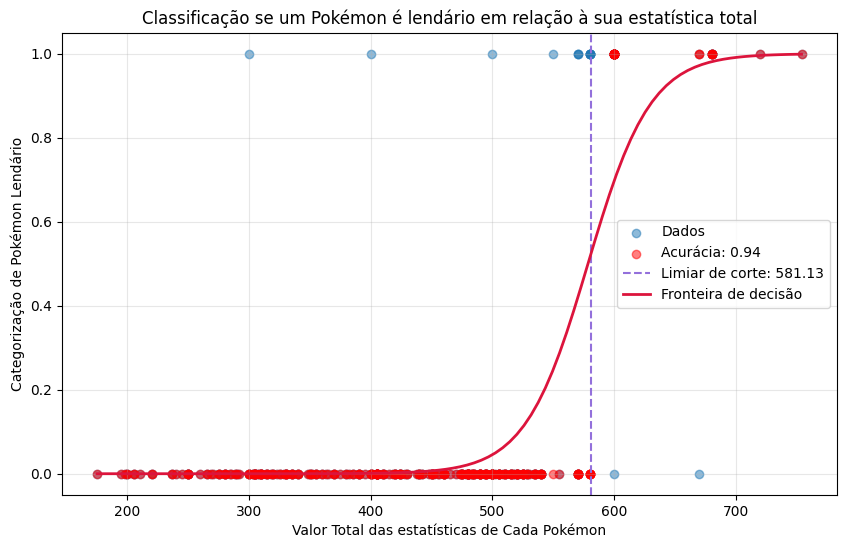

In [181]:
acuracia = accuracy_score(y_test, ypred)
cutoff_point = - model.intercept_ / model.coef_[0]
x_line = np.linspace(np.min(X_test), np.max(X_test), 100)
y_line = modelo.predict_proba(x_line.reshape(-1, 1))[:, 1]



plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label='Dados', alpha=0.5)
plt.scatter(X_test, ypred, color='red', label=f'Acurácia: {acuracia:.2f}', alpha=0.5)
plt.axvline(x=cutoff_point, color='mediumpurple', linestyle='--', label=f'Limiar de corte: {cutoff_point[0]:.2f}')
plt.plot(x_line, y_line, color='crimson', label='Fronteira de decisão', linewidth=2)
plt.xlabel("Valor Total das estatísticas de Cada Pokémon")
plt.ylabel("Categorização de Pokémon Lendário")
plt.title("Classificação se um Pokémon é lendário em relação à sua estatística total")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

A alta acurácia obtida pelo modelo de classificação linear do Scikit-learn indica que Pokémon com estatísticas totais mais elevadas têm uma maior probabilidade de serem classificados como lendários. O modelo estabeleceu um limiar de corte na curva sigmoide, definido em 581,13, onde todos os Pokémon com estatísticas totais acima desse valor foram classificados como lendários durante os testes. Esses resultados afirma que há uma relação entre a classificação de um Pokémon como lendário e suas estatísticas totais. Portanto, é possível concluir que que as estatísticas totais é um forte indicativo para de determinação da classificação se um Polémon é ou não lendário, conforme previsto pelo modelo de classificação linear utilizado.

<br>
<br>
<br>
<br>
<br>

### K-Nearest Neighbors (KNN)

A ideia principal do KNN (K-Nearest Neighbors) é prever o valor ou a classe de um ponto de dados com base nos pontos de dados mais próximos no espaço de características. No universo Pokémon, os Pokémons do tipo Água são geralmente poderosos e se tornam ainda mais fortes quando evoluem para seu estágio final. No entanto, como se trata de um jogo, a lógica de evolução pode ser alterada em prol da diversão e de outras considerações de desenvolvimento. Isso resulta em situações onde um Pokémon completamente evoluído pode ser mais fraco do que um Pokémon básico ou em estágio intermediário.

O objetivo desta parte do trabalho é classificar corretamente os Pokémons do tipo água (e sem tipo segundário) por estágios de evolução (Basic e Stage 1 apenas). Será utilizado o algoritmo K-Nearest Classifier, que é a variação do algoritmo K-Nearest Neighbors para problemas de classificação. Para isso, utilizaremos apenas as informações das estatísticas de ataque (attack) e ataque especial (sp_attack), além das informações de estágio do nível evolutivo dos Pokémon.

##### Tratamento dos Dados

Primeiro, precisamos separar os dados de interesse para o treinamento. Os dados de interesse são os Pokémon cujo tipo primário é __água__, não possuem um tipo secundário, não são lendários e não são dos estágios bebes e estágio 2.

In [251]:
selected_pkmn = data.loc[
    (data['type1'] == 'Water') &
    (data['type2'].isnull()) &
    (data['legendary'] == False) &
    (data['stage'] != 'Baby') &
    (data['stage'] != 'Stage 2')
]

Para realizar a classificação dos dados, vamos separar as características __ataque__ e __ataque especial__ para serem os dados da variável independente (X) e a __classificação de estágio__ para serem os dados da variável dependente (y).

In [252]:
X = selected_pkmn[['attack', 'sp_attack']].values
y = selected_pkmn['stage'].values

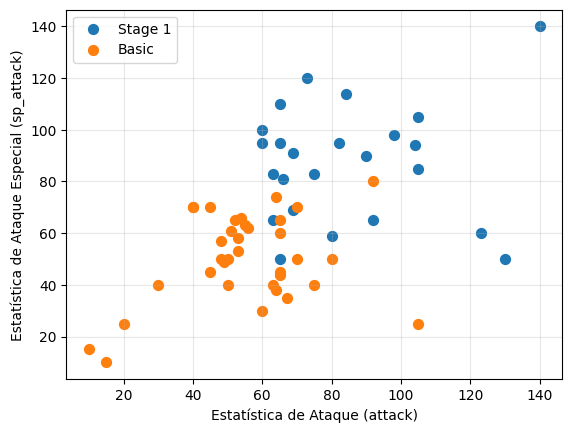

In [253]:
for stage in set(y):
    plt.scatter(X[y == stage, 0], X[y == stage, 1], s=50, label=f'{stage}')
plt.xlabel('Estatística de Ataque (attack)')
plt.ylabel('Estatística de Ataque Especial (sp_attack)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

##### Algoritmo

O código abaixo representa uma implementação do algoritmo K-Nearest Neighbor (KNN). O método fit() armazena os dados de entrada (X) e seus respectivos alvos (y) que são passados como parâmetros. Na função predict(), o algoritmo calcula a distância Euclidiana entre cada elemento de entrada e os dados de treinamento (self.X). Em seguida, determina a classificação mais frequente entre os vizinhos mais próximos desse elemento para prever a classificação do novo dado de entrada.

In [270]:
class KNeighborsClassifier_M(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors

  def fit(self, X, y):
    self.X = X
    self.y = y
    
  def distance(self, X):
    difference = self.X - X
    squared = difference ** 2
    summed = np.sum(squared, axis=1)
    root = np.sqrt(summed)
    return root
  
  def predict(self, X):
    y_pred = np.empty((X.shape[0],), dtype=object)
    for i in range(X.shape[0]):
      distances = self.distance(X[i])
      nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
      neighbor_labels = self.y[nearest_neighbors]
      unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
      y_pred[i] = unique_labels[np.argmax(counts)]
    return y_pred
  

modelo = KNeighborsClassifier_M(n_neighbors=1)
modelo.fit(X, y)
ypred = modelo.predict(X)
acuracia = accuracy_score(y, ypred)
acuracia

1.0

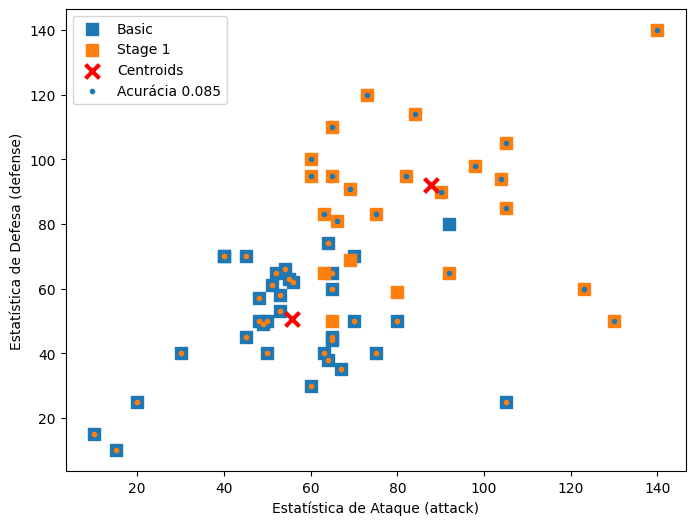

In [186]:
stage_names = ['Basic', 'Stage 1']
ypred_n = np.array([])
kmeans_m = KMeans_M()
kmeans_m.fit(X, y)
ypred = kmeans_m.predict(X)

for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

acuracia = accuracy_score(y, ypred_n)


plt.figure(figsize=(8,6))

for stage in stage_names:
  plt.scatter(X[y == stage, 0], X[y == stage, 1], s=75, label=f'{stage}', marker='s')

plt.scatter(kmeans_m.cluster_centers_[:,0], kmeans_m.cluster_centers_[:,1], marker="x", color="r", s=100, linewidths=3, label="Centroids")

for i in stage_names:
  plt.plot(X[ypred_n==i, 0], X[ypred_n==i, 1], ".", label=f'Acurácia {acuracia:.3f}' if i == "Basic" else None)


plt.xlabel("Estatística de Ataque (attack)")
plt.ylabel("Estatística de Defesa (defense)")
plt.legend()
plt.show()

Para analisar o desempenho do algoritmo implementado, abaixo é importado o modelo KMeans() da biblioteca Scikit-learn. Em tese, tanto a implementação manual quanto o modelo importado devem apresentar os mesmos resultados.

A única diferença encontrada pelo autor deste documento foi a capacidade do modelo de Regressão Linear da biblioteca Scikit-learn de utilizar os dados de entrada (X) sem a necessidade de estarem padronizados. O modelo manual apresenta problemas de overflow devido à diferença entre a escala dos valores de __X__ e __y__.

In [187]:
# Regressão Linear do modelo presente em sklearn

from sklearn.neighbors import KNeighborsClassifier

modelo = KNeighborsClassifier(n_neighbors=)
modelo.fit()

O KMeans da biblioteca do Scikit-learn possui o parâmetro __n_init__. Ao definir um inteiro para esse parâmetro, o usuário indica ao algoritmo quantos reinícios aleatórios dos centroids poderá ser realizados. Basicamente o __n_init__ realiza a mesma lógica do loop implementado no KMeans_M() para buscar pela solução ótima possível.

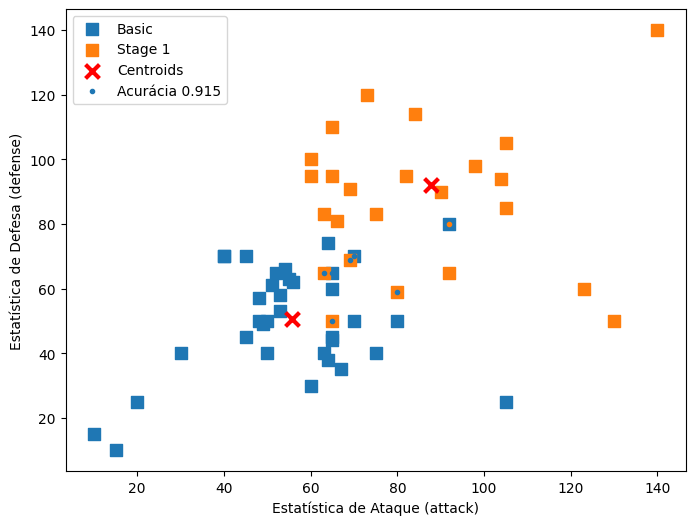

In [188]:
stage_names = ['Basic', 'Stage 1']

ypred_n = np.array([])
kmeans = KMeans(n_clusters=2, n_init=100)
kmeans.fit(X)
ypred = kmeans.predict(X)

for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

acuracia = accuracy_score(y, ypred_n)


plt.figure(figsize=(8,6))

for stage in stage_names:
  plt.scatter(X[y == stage, 0], X[y == stage, 1], s=75, label=f'{stage}', marker='s')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="x", color="r", s=100, linewidths=3, label="Centroids")

for i in stage_names:
  plt.plot(X[ypred_n==i, 0], X[ypred_n==i, 1], ".", label=f'Acurácia {acuracia:.3f}' if i == "Basic" else None)


plt.xlabel("Estatística de Ataque (attack)")
plt.ylabel("Estatística de Defesa (defense)")
plt.legend()
plt.show()

### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo KMeans possui dois parâmetros bastante relevantes: **n_clusters** e **n_init**. O parâmetro n_clusters define a quantidade de centróides e, consequentemente, a quantidade de grupos a serem criados. Já o parâmetro **n_init** define quantas vezes o algoritmo será executado com diferentes centroids iniciais, a fim de encontrar a melhor classificação dos elementos.

Neste trabalho, não vamos testar valores os parâmetros para os Kmeans. O **n_clusters** teve ter seu valor definido em 2, pois queremos classificar os Pokémon em dois grupos (Basic ou Stage 1). Já o **n_init** só precisa ser o suficiênte para que todas as execuções resultem na solução ótima.

### Captura e Interpretação dos resultados

Ambos os algoritmos tiveram o mesmo valor de acurácia. Então será escolhido o algortimo da biblioteca do Scikit-learn para a capturação e interpretação dos resultados.

Apesar de não ter realizados testes de desempenho com o GridSearchCV e com o cross_validate, essa fato não invalida a necessidade de separar os dados entre treino e teste.

In [241]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [242]:
# Treinamento do modelo com os dados de treinamento.

model = KMeans(n_clusters=2, n_init=100)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

O modelo treinado com LinearRegression() apresentou um coeficiente de 2,729 e um intercepto de 217,601. Isso indica que, para cada aumento de 1 ponto no atributo de Ataque de um Pokémon, espera-se um acréscimo de aproximadamente 2,729 pontos nas estatísticas Totais, além de uma constante de 217,601 pontos.

In [243]:
ypred_n = np.array([])
for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

accuracy = accuracy_score(y_test, ypred_n)
accuracy

0.9444444444444444

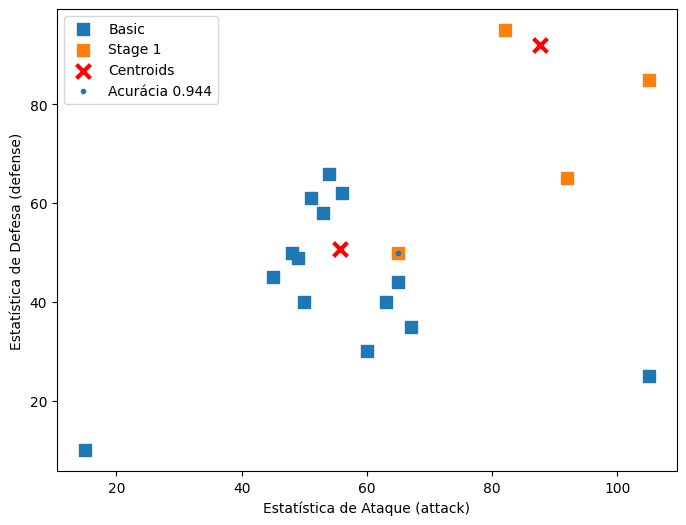

In [244]:
plt.figure(figsize=(8,6))

for stage in stage_names:
  plt.scatter(X_test[y_test == stage, 0], X_test[y_test == stage, 1], s=75, label=f'{stage}', marker='s')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="x", color="r", s=100, linewidths=3, label="Centroids")

for i in stage_names:
  plt.plot(X_test[ypred_n==i, 0], X_test[ypred_n==i, 1], ".", label=f'Acurácia {accuracy:.3f}' if i == "Basic" else None)


plt.xlabel("Estatística de Ataque (attack)")
plt.ylabel("Estatística de Defesa (defense)")
plt.legend()
plt.show()

Todo fã da franquia Pokémon sabe que os Pokémon evoluiem para seu estágio superior com o objetivo de ficar mais forte, e se isso é verdade, estatísticas de Pokémons menos evoluídos serão menores em comparação dos mais evoluídos. Se houver essa diferenciação, então é possível categorizar os Pokémon em estágios de evolução utilizando a distância Euclidiana.

Ao alcançar 94% de acurácia sobre a previsão de qual estágio (Basic ou Este 1) os Pokémon são, podemos afirmar que é verdadeiro que a evolução deixa os Pokémon mais fortes, porém que há excessões.

<br>
<br>
<br>
<br>
<br>

***

# MODELO

Com o método da regressão, queremos prever um valor contínuo de variáveis independentes em relação a uma variável dependente. O valor total (total) das estatísticas do Pokémon está relacionado com os valores de todas as estatísticas, então podemos observar que, se um Pokémon tem um valor de ataque (attack) muito alto, é provavel que o seu total (total) também sejá alto.

Para observar essa relação, utilizaremos a regressão linear para prever o valor total (total) de um Pokémon fornecendo somente seu valor de ataque (attack).

### Tratamento dos Dados

Separar os dados da variável independente (X) e os dados da variável dependente (y).

In [ ]:
X = data['attack'].values.reshape(-1,1)
y = data['total'].values

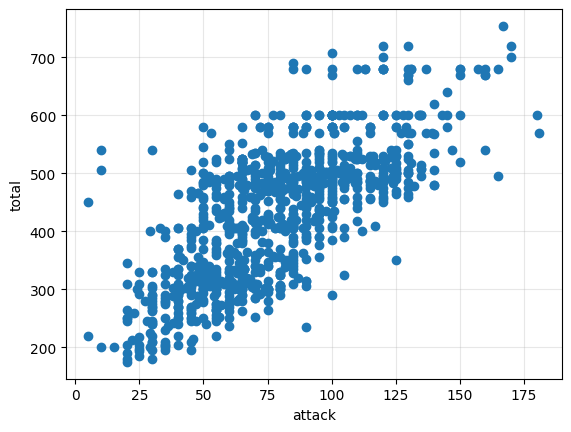

In [ ]:
plt.xlabel(f"{data['attack'].name}")
plt.ylabel(f"{data['total'].name}")
plt.scatter(data['attack'], data['total'], zorder=2)
plt.grid(alpha=0.3)
plt.show()

### Algoritmos

Abaixo está o algoritmo de Regressão Linear "manualmente" implementado. O algoritmo contém o método fit() para treinar os pesos (w) e utilizá-los posteriormente no método predict(). O algoritmo também contém um método de adição de bias para não ficar preso na origem.

Raiz do Erro Quadrático Médio (RMSE): 79.51881458945789


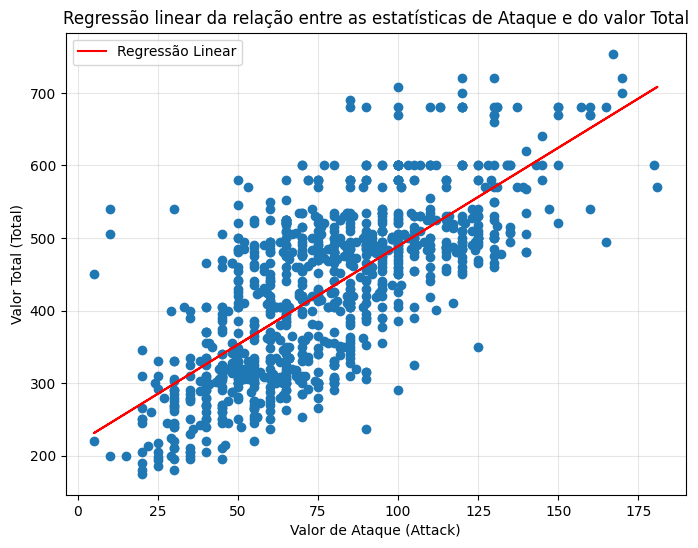

In [ ]:
# Regressão Linear

class LinearRegression_M(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self, learning_rate=0.1, n_iter=500):
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.w = np.zeros((2,1))
  
  @staticmethod
  def addBias(X):
    bias = np.ones((X.shape[0],1))
    X_b = np.concatenate((bias,X),axis=1)
    return X_b
  
  def fit(self, X, y):
    X_b = self.addBias(X)
    for _ in range(self.n_iter):
      ypred = self.predict(X)
      erro = ypred - y.reshape(-1,1)
      ajuste = X_b.T.dot(erro)/X_b.shape[0]
      self.w = self.w - self.learning_rate * ajuste

  def predict(self, X):
    X_b = self.addBias(X)
    y = X_b.dot(self.w)
    return y



linearRegression_m = LinearRegression_M()
linearRegression_m.fit(X_new, y)
ypred = linearRegression_m.predict(X_new)

print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse(y,ypred)}")
plt.figure(figsize=(8,6))
plt.scatter(X, y, zorder=2)
plt.title("Regressão linear da relação entre as estatísticas de Ataque e do valor Total")
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.plot(X, ypred, 'r', label="Regressão Linear")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Para fins de comparação, abaixo é importado o modelo LinearRegression() da biblioteca Scikit-learn. Em tese, tanto a implementação manual quanto o modelo importado devem apresentar os mesmos resultados.

A única diferença encontrada pelo autor deste documento foi a capacidade do modelo de Regressão Linear da biblioteca Scikit-learn de utilizar os dados de entrada (X) sem a necessidade de estarem padronizados. O modelo manual apresenta problemas de overflow devido à diferença entre a escala dos valores de __X__ e __y__.

Raiz do Erro Quadrático Médio (RMSE): 79.51881458945789


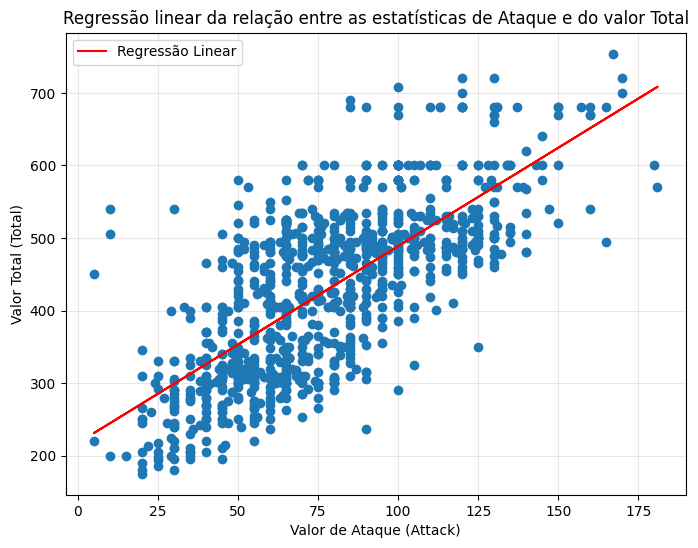

In [ ]:
# Regressão Linear do modelo presente em sklearn

from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()
linearRegression.fit(X, y)
ypred = linearRegression.predict(X)



print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse(y,ypred)}")
plt.figure(figsize=(8,6))
plt.scatter(X, y, zorder=2)
plt.title("Regressão linear da relação entre as estatísticas de Ataque e do valor Total")
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.plot(X, ypred, 'r', label="Regressão Linear")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo de Regressão Linear "manual" possui dois parâmetros principais: o n_iter, que determina quantas iterações o método fit() realizará durante o treinamento dos pesos (w), e o learning_rate, que define a taxa de aprendizado aplicada em cada iteração.

Por outro lado, o algoritmo da biblioteca do Scikit-learn utiliza estratégias internas otimizadas para obter resultados eficientes. Portanto, não é necessário submetê-lo ao GridSearchCV() para busca de melhores parâmetros, pois essas otimizações já são implementadas internamente.

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_validate

parameters = {
  'n_iter':[20, 100, 500, 1000],
  'learning_rate': [0.001, 0.01, 0.1]
  }

gs_lrm_model = GridSearchCV(LinearRegression_M(), parameters, scoring="neg_root_mean_squared_error")
linearReg_M_scores = cross_validate(gs_lrm_model, X_new, y, scoring="neg_root_mean_squared_error")

linearReg_scores = cross_validate(LinearRegression(), X_new, y, scoring="neg_root_mean_squared_error")

***

# Aprendizado Não Supervisionado

A ideia principal do KNN (K-Nearest Neighbors) é prever o valor ou a classe de um ponto de dados com base nos pontos de dados mais próximos no espaço de características. No universo Pokémon, os Pokémons do tipo Água são geralmente poderosos e se tornam ainda mais fortes quando evoluem para seu estágio final. No entanto, como se trata de um jogo, a lógica de evolução pode ser alterada em prol da diversão e de outras considerações de desenvolvimento. Isso resulta em situações onde um Pokémon completamente evoluído pode ser mais fraco do que um Pokémon básico ou em estágio intermediário.

O objetivo desta parte do trabalho é classificar corretamente os Pokémons do tipo água (e sem tipo segundário) por estágios de evolução (Basic e Stage 1 apenas). Será utilizado o algoritmo K-Nearest Neighbors (KNN). Para isso, utilizaremos apenas as informações das estatísticas de ataque (attack) e ataque especial (sp_attack)

##### Tratamento dos Dados

Primeiro, precisamos separar os dados de interesse para o treinamento. Os dados de interesse são os Pokémon cujo tipo primário é __água__, não possuem um tipo secundário, não são lendários e não são dos estágios bebes e estágio 2.

In [ ]:
selected_pkmn = data.loc[
    (data['type1'] == 'Water') &
    (data['type2'].isnull()) &
    (data['legendary'] == False) &
    (data['stage'] != 'Baby') &
    (data['stage'] != 'Stage 2')
]

Para realizar a classificação dos dados, vamos separar as características __ataque__ e __ataque especial__ para serem os dados da variável independente (X) e a __classificação de estágio__ para serem os dados da variável dependente (y).

In [ ]:
X = selected_pkmn[['attack', 'sp_attack']].values
y = selected_pkmn['stage'].values

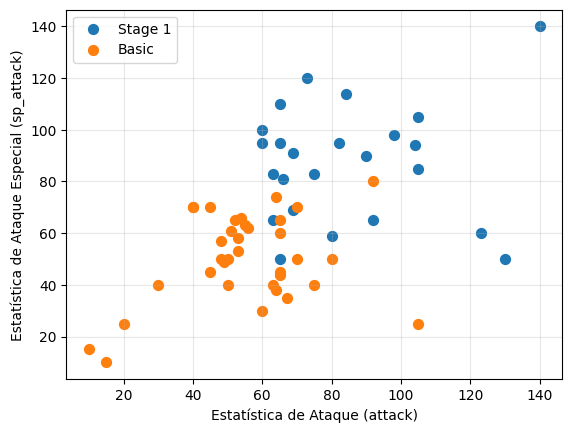

In [ ]:
for stage in set(y):
    plt.scatter(X[y == stage, 0], X[y == stage, 1], s=50, label=f'{stage}')
plt.xlabel('Estatística de Ataque (attack)')
plt.ylabel('Estatística de Ataque Especial (sp_attack)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

##### Algoritmo

O código abaixo é uma implementação do algoritmo K-Nearest Neighbors. A função __fit()__ gera a quantidade de centroids iniciais em posições aleatórias definidas pelo usuário por meio da função **_init_centroids()**. Ao longo das iterações, a função __fit()__ aproxima os centroids de acordo com os elementos mais próximos pela distância Euclidiana calculada por **_distancias()**. O algoritmo completa o seu treinamento quando nenhum centroid se move de lugar.

In [ ]:
class KMeans_M(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self, n_clusters=2, n_init=1):
    self.n_clusters = n_clusters
    self.n_init = n_init

  def _init_centroids(self, X):
    min = np.min(X, axis=0)
    max = np.max(X, axis=0)
    centroids = []
    for i in range(self.n_clusters):
      centroid = []
      for j in range(X.shape[1]):
        centroid.append(random.uniform(min[j], max[j]))
      centroids.append(centroid)
      self.cluster_centers_ = np.array(centroids)

  def fit(self, X, y=None):
    best_accuracy = 0
    best_cluster_centers_ = None

    unique_classes = list(set(y))
    y_int = np.array([unique_classes.index(label) for label in y])

    for _ in range(self.n_init):
      self._init_centroids(X)
      previous_centroids = self.cluster_centers_.copy()
      while True:
        ypred = self.predict(X)
        for i in range(self.n_clusters):
          if np.any(ypred==i):
              self.cluster_centers_[i] = np.mean(X[ypred==i], axis=0)
        if np.allclose(previous_centroids, self.cluster_centers_, atol=0.0001):
          break
        previous_centroids = self.cluster_centers_.copy()

      ypred = self.predict(X)
      accuracy = sum(y_int == ypred)/len(ypred)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_cluster_centers_ = self.cluster_centers_
    self.cluster_centers_ = best_cluster_centers_
  
  def _distancias(self, X):
    diferenca = self.cluster_centers_ - X
    quadrado = diferenca ** 2
    soma = np.sum(quadrado, axis=1)
    raiz = np.sqrt(soma)
    return raiz

  def predict(self, X):
    ypred = np.empty((X.shape[0],))
    for i in range(X.shape[0]):
      distancias = self._distancias(X[i])
      centroid = np.argmin(distancias)
      ypred[i] = centroid
    return ypred

O __KMeans_()__ iniciar com centroids em posições aleatórias e por causa dessa características, o algoritmo pode iniciar com valores que impedem o melhor resultado, ficando preso em um máximo local. Para garantir uma solução ótima para o exemplo de execução desse algorimo, é realizado 50 reinícios.

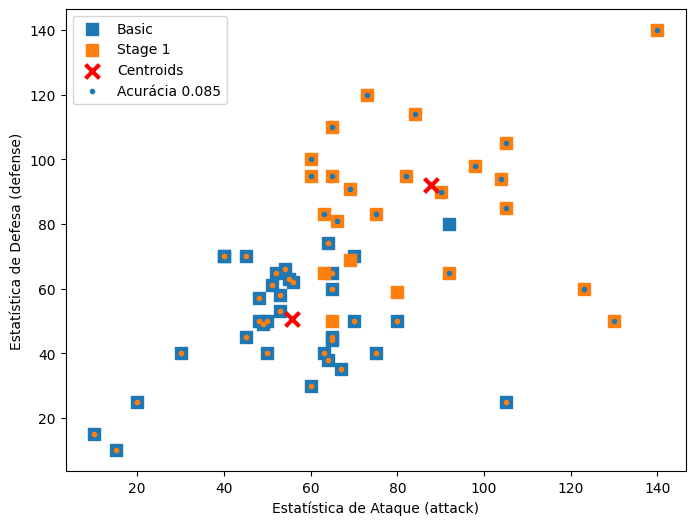

In [ ]:
stage_names = ['Basic', 'Stage 1']
ypred_n = np.array([])
kmeans_m = KMeans_M()
kmeans_m.fit(X, y)
ypred = kmeans_m.predict(X)

for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

acuracia = accuracy_score(y, ypred_n)


plt.figure(figsize=(8,6))

for stage in stage_names:
  plt.scatter(X[y == stage, 0], X[y == stage, 1], s=75, label=f'{stage}', marker='s')

plt.scatter(kmeans_m.cluster_centers_[:,0], kmeans_m.cluster_centers_[:,1], marker="x", color="r", s=100, linewidths=3, label="Centroids")

for i in stage_names:
  plt.plot(X[ypred_n==i, 0], X[ypred_n==i, 1], ".", label=f'Acurácia {acuracia:.3f}' if i == "Basic" else None)


plt.xlabel("Estatística de Ataque (attack)")
plt.ylabel("Estatística de Defesa (defense)")
plt.legend()
plt.show()

Para analisar o desempenho do algoritmo implementado, abaixo é importado o modelo KMeans() da biblioteca Scikit-learn. Em tese, tanto a implementação manual quanto o modelo importado devem apresentar os mesmos resultados.

A única diferença encontrada pelo autor deste documento foi a capacidade do modelo de Regressão Linear da biblioteca Scikit-learn de utilizar os dados de entrada (X) sem a necessidade de estarem padronizados. O modelo manual apresenta problemas de overflow devido à diferença entre a escala dos valores de __X__ e __y__.

In [ ]:
# Regressão Linear do modelo presente em sklearn

from sklearn.cluster import KMeans

O KMeans da biblioteca do Scikit-learn possui o parâmetro __n_init__. Ao definir um inteiro para esse parâmetro, o usuário indica ao algoritmo quantos reinícios aleatórios dos centroids poderá ser realizados. Basicamente o __n_init__ realiza a mesma lógica do loop implementado no KMeans_M() para buscar pela solução ótima possível.

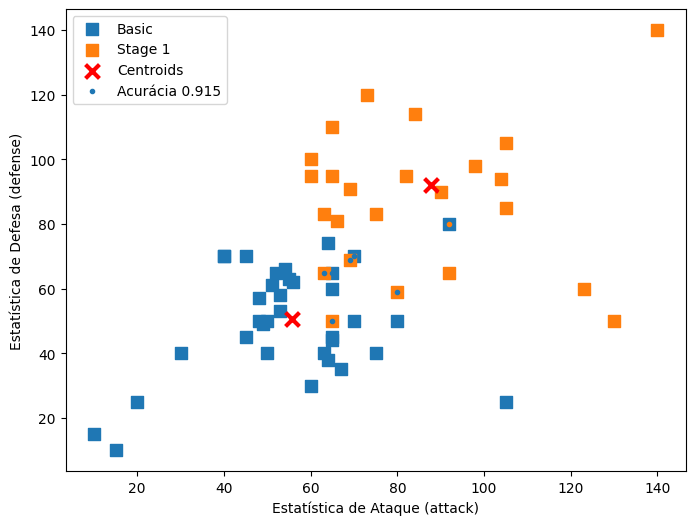

In [ ]:
stage_names = ['Basic', 'Stage 1']

ypred_n = np.array([])
kmeans = KMeans(n_clusters=2, n_init=100)
kmeans.fit(X)
ypred = kmeans.predict(X)

for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

acuracia = accuracy_score(y, ypred_n)


plt.figure(figsize=(8,6))

for stage in stage_names:
  plt.scatter(X[y == stage, 0], X[y == stage, 1], s=75, label=f'{stage}', marker='s')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="x", color="r", s=100, linewidths=3, label="Centroids")

for i in stage_names:
  plt.plot(X[ypred_n==i, 0], X[ypred_n==i, 1], ".", label=f'Acurácia {acuracia:.3f}' if i == "Basic" else None)


plt.xlabel("Estatística de Ataque (attack)")
plt.ylabel("Estatística de Defesa (defense)")
plt.legend()
plt.show()

### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo KMeans possui dois parâmetros bastante relevantes: **n_clusters** e **n_init**. O parâmetro n_clusters define a quantidade de centróides e, consequentemente, a quantidade de grupos a serem criados. Já o parâmetro **n_init** define quantas vezes o algoritmo será executado com diferentes centroids iniciais, a fim de encontrar a melhor classificação dos elementos.

Neste trabalho, não vamos testar valores os parâmetros para os Kmeans. O **n_clusters** teve ter seu valor definido em 2, pois queremos classificar os Pokémon em dois grupos (Basic ou Stage 1). Já o **n_init** só precisa ser o suficiênte para que todas as execuções resultem na solução ótima.

### Captura e Interpretação dos resultados

Ambos os algoritmos tiveram o mesmo valor de acurácia. Então será escolhido o algortimo da biblioteca do Scikit-learn para a capturação e interpretação dos resultados.

Apesar de não ter realizados testes de desempenho com o GridSearchCV e com o cross_validate, essa fato não invalida a necessidade de separar os dados entre treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Treinamento do modelo com os dados de treinamento.

model = KMeans(n_clusters=2, n_init=100)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

O modelo treinado com LinearRegression() apresentou um coeficiente de 2,729 e um intercepto de 217,601. Isso indica que, para cada aumento de 1 ponto no atributo de Ataque de um Pokémon, espera-se um acréscimo de aproximadamente 2,729 pontos nas estatísticas Totais, além de uma constante de 217,601 pontos.

In [ ]:
ypred_n = np.array([])
for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

accuracy = accuracy_score(y_test, ypred_n)
accuracy

0.9444444444444444

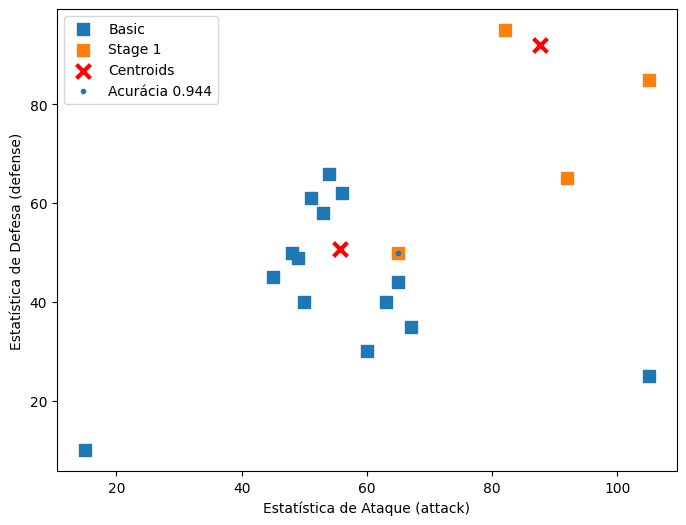

In [ ]:
plt.figure(figsize=(8,6))

for stage in stage_names:
  plt.scatter(X_test[y_test == stage, 0], X_test[y_test == stage, 1], s=75, label=f'{stage}', marker='s')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="x", color="r", s=100, linewidths=3, label="Centroids")

for i in stage_names:
  plt.plot(X_test[ypred_n==i, 0], X_test[ypred_n==i, 1], ".", label=f'Acurácia {accuracy:.3f}' if i == "Basic" else None)


plt.xlabel("Estatística de Ataque (attack)")
plt.ylabel("Estatística de Defesa (defense)")
plt.legend()
plt.show()

Todo fã da franquia Pokémon sabe que os Pokémon evoluiem para seu estágio superior com o objetivo de ficar mais forte, e se isso é verdade, estatísticas de Pokémons menos evoluídos serão menores em comparação dos mais evoluídos. Se houver essa diferenciação, então é possível categorizar os Pokémon em estágios de evolução utilizando a distância Euclidiana.

Ao alcançar 94% de acurácia sobre a previsão de qual estágio (Basic ou Este 1) os Pokémon são, podemos afirmar que é verdadeiro que a evolução deixa os Pokémon mais fortes, porém que há excessões.

<br>
<br>
<br>
<br>
<br>